# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- title: Parcels
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I love freebies. In my opinion, guestbooks are the ticket to a bunch of em!

So what's the best way to find em all?

Perhaps the same way to find out a lot of really cool information... 🤔

## Parcel Data

In [1]:
#hide 
!pip install matplotlib
!pip install geopandas
!pip install folium

You should consider upgrading via the '/workspaces/CVminiGames.github.io/.venv/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/workspaces/CVminiGames.github.io/.venv/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/workspaces/CVminiGames.github.io/.venv/bin/python3.8 -m pip install --upgrade pip' command.


For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json)

In [2]:
#hide 
import requests
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 

In [3]:
#hide 
import pandas as pd
import geopandas as gpd
gdf = { "type": "FeatureCollection", "features": [] }
for obj in data:
  feat = { "type": "Feature", "geometry": { "type": "Polygon", "coordinates": [ ] }, "properties": { } }
  feat['geometry']['coordinates'] = obj['geometry']['coordinates'] 
  feat['properties'] = {key: obj[key] for key in obj if key not in ['x1','x2','y1','y2','z1','z2','geometry']}
  gdf['features'].append(feat)  

# What fresh hell have I done here?
with open('../data/cv.geojson', 'w') as outfile: json.dump(gdf, outfile)
  
gdf = gpd.read_file('../data/cv.geojson')
gdf['id'] = gdf.id.astype(str) 
gdf['vol'] = gdf['area'] * gdf['height'] 
gdf.to_file("../data/cv.geojson", driver='GeoJSON')

/workspaces/CVminiGames.github.io/.venv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
#hide 
import folium
import branca
import branca.colormap as cm
from branca.colormap import linear

In [5]:
#hide 
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma 
# https://python-visualization.github.io/branca/colormap.html 
t = """
mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) 
colormap = cm.LinearColormap(colors=['white', 'blue','green', 'yellow', 'orange', 'red'], caption="Parcel Volume").to_step(data=gdf['vol'], method='quant', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1]) 
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['vol']), 'fillOpacity':0.75} 
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1} 

layer = folium.FeatureGroup(name='your layer name', show=False) 
temp_geojson = folium.GeoJson(gdf) 
for feature in temp_geojson.data['features']: 
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>' 
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>' 
    innerHTML += '<b> Height - ' +str(feature['properties']['height']) + '</b><br>' 
    innerHTML += '<b> Area - ' +str(feature['properties']['area']) + '</b><br>' 
    innerHTML += '<b> Volume - ' +str(feature['properties']['vol']) + '</b><br>' 
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda txt, source: f"<div id='popupIFrame' style='white-space: nowrap;' align='center''> <a href='{source}'> Visit </a><br>{txt}</div>"
    folium.Popup( html=foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer) 
    temp_layer.add_to(layer) 

layer.add_to(mymap) 
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_vol_map.html') 
"""

In [6]:
#hide 
# df = gdf[gdf['island'] == 'Scarcity'] # Only Scarcity Island 
# gdf[gdf['island']=='Scarcity']['island'].describe()
# gdf[gdf['island']=='Scarcity'].plot()

The data contains geocoordinates and a bit of meta data which can let us do fun stuff like this <a href="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"> map </a>.

Where: 
- Color depicts volume broke out by quartile.

- And the top largest 2% and 1% of parcels painted orange and red, respectively.

In [7]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"/>

We can do other things. 

Here is a frequency plot of Flora Islands Volume (excluding it's outlier)

<AxesSubplot:ylabel='Frequency'>

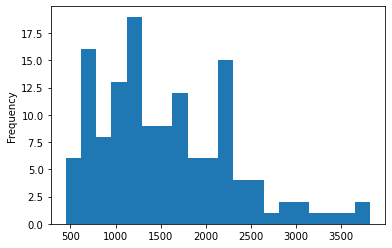

In [8]:
#hide_input 
t = gdf[gdf['island']=='Flora']
q_low = t["vol"].quantile(0.01)
q_hi  = t["vol"].quantile(0.99)
t = t[(t["vol"] < q_hi) & (t["vol"] > q_low)]
t['vol'].plot.hist(bins=20)

Ok. So thats nice...

I'll do more exploration on this end some time later...

What else can we do?

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel # to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

In [10]:
#hide
t = """
# This code will save each parcel features data
import requests
import json 
errors = []
for index, row in gdf.iterrows():
  url = 'https://www.cryptovoxels.com/api/parcels/'+str(row['id'])+'.json' 
  r = requests.get(url)
  if r.status_code == 404: errors.push(str(row['id'])); print('error', str(row['id'])); continue
  data = json.loads(r.text) 
  with open('../data/parcels/'+str(row['id'])+'.json', 'w') as file:
    json.dump(data, file)
"""

In [23]:
import json
from shapely.geometry import Polygon
from os.path import exists
pd.options.display.max_colwidth = 500
deets = [] 

for index, row in gdf.iterrows():  
  url = '../data/parcels/'+str(row['id'])+'.json' 
  if not exists(url): print('noexisst', str(row['id'])); continue
  data = ''  
  with open(url, 'r') as j: data = json.loads(j.read())['parcel'] 
  flag = False
  if data['content'] == None: flag = True 
  elif 'features' not in data['content']: flag = True
  newobj = {key: data[key] for key in data if key in ['id', 'x1','x2','y1','y2','z1','z2', 'traffic_visits','contributors','description', 'sandbox', 'lightmap_status', 'kind']} 
  if flag: newobj['built'] = 0; newobj['book'] = 0
  else:
    newobj['built'] = 1
    guestbook = list(filter(lambda x: x['type'] == 'guest-book', data['content']['features'])) 
    newobj['book'] = 1 if guestbook else  0 
  deets.append( newobj )


In [24]:
book = pd.json_normalize(data=deets).convert_dtypes() 
book['contributors'] = book['contributors'].astype(str)
book['id'] = book['id'].astype(str) 
book['book'] = book['book'].astype(float) 
bookgdf = gpd.GeoDataFrame( pd.merge(gdf, book, on="id", how='left'), geometry='geometry', crs='epsg:3857') 

<AxesSubplot:>

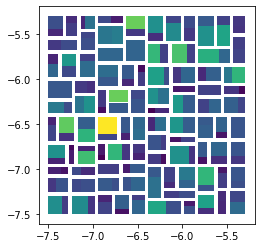

In [30]:
gdf[gdf['island']=='Berlin'].plot(column='vol')  

<AxesSubplot:>

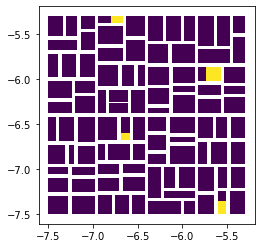

In [31]:
bookgdf[bookgdf['island']=='Berlin'].plot(column='book')  

In [42]:
#hide 
import numpy as np
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma 
# https://python-visualization.github.io/branca/colormap.html 

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) 
colormap = cm.LinearColormap(colors=['white', 'green'], caption="Parcel Volume")
style_function = lambda x: {
    "weight":0.5, 'color':'black', 
    'fillColor': 'black' if np.isnan(x['properties']['book']) else colormap(x['properties']['book']), 'fillOpacity':0.75
} 
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1} 
colormap

In [43]:

layer = folium.FeatureGroup(name='your layer name', show=False)
for feature in folium.GeoJson(bookgdf).data['features']: 
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>' 
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>' 
    innerHTML += '<b> Height - ' +str(feature['properties']['height']) + '</b><br>' 
    innerHTML += '<b> Area - ' +str(feature['properties']['area']) + '</b><br>' 
    innerHTML += '<b> Volume - ' +str(feature['properties']['vol']) + '</b><br>' 
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda txt, source: f"<div id='popupIFrame' style='white-space: nowrap;' align='center''> <a href='{source}'> Visit </a><br>{txt}</div>"
    folium.Popup( html=foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer) 
    temp_layer.add_to(layer) 

layer.add_to(mymap) 
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_book_map.html') 

In [44]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_book_map.html"/>

In [ ]:
#hide_input 
# testgdf[ ( testgdf['book-position'].notnull() ) ].drop(columns=['geometry'])[['link','book-position']].head(5)

In [ ]:
bookgdf.to_file("../data/guest-books.geojson")

In [ ]:
import pandas as pd
df90 = pd.read_csv("https://www.k1ic.com/traffic_archive/cv_all_parcel_90day_traffic.csv")
df90['parcel_id'] = df90['parcel_id'].astype(int)
gdf['id'] = gdf['id'].astype(int)
tdf = gdf.merge(df90, left_on='id', right_on='parcel_id', how='right')
tdf = tdf.sort_values(by=["90day_traffic_total"])
tdf['90day_traffic_total'] = tdf['90day_traffic_total'].fillna(0)
tdf.to_file("cv_map.geojson", driver='GeoJSON')

In [ ]:
tdf.sort_values(by='90day_traffic_total')

In [ ]:
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma
# https://python-visualization.github.io/branca/colormap.html

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True)
colormap = cm.LinearColormap(colors=['white','blue','black', 'red', 'green'], caption="Parcel Volume").to_step(data=tdf['90day_traffic_total'], method='quant', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1])
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['90day_traffic_total']), 'fillOpacity':0.75}
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}

layer = folium.FeatureGroup(name='your layer name', show=False)
temp_geojson = folium.GeoJson('cv_map.geojson')
for feature in temp_geojson.data['features']:  
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>'
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>'
    innerHTML += '<b> 90 Day Traffic - ' +str(feature['properties']['90day_traffic_total']) + '</b><br>'
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda name, source: f""" <a id="popupIFrame" width="600" height="200" align="center" href="{source}"> {name} </a> """
    folium.Popup( html=foo(feature["properties"]["address"], f'www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer)
    temp_layer.add_to(layer)

layer.add_to(mymap)
colormap.add_to(mymap) 